In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True

In [35]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')


print(df.isna().sum())

df = df.rename(columns={'ROH_med':'ROH'})
df['DOA'] = pd.to_datetime(df['DOA'])

df['DOW'] = df['DOA'].dt.dayofweek
df['Mon'] = df['DOA'].dt.month
df['Day'] = df['DOA'].dt.day

# just to make DOA unique
df['DOA'] = df['DOA']+df['DBA'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 
df = df.set_index('DOA')

HotelId
DOA        0
DBA        0
ROH_max    0
ROH_min    0
ROH_med    0
ROH_avg    0
ROH_std    0
DOW        0
LAR_max    0
LAR_min    0
LAR_med    0
LAR_avg    0
LAR_std    0
dtype: int64


In [36]:
df.head()

HotelId,DBA,ROH_max,ROH_min,ROH,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,Mon,Day
DOA,,,,,,,,,,,,,,
2018-01-01 23:44:00,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 23:28:00,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 21:04:00,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:48:00,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.5,38.69,72.9,75.847778,30.871318,1,1
2018-01-01 20:32:00,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.5,38.69,72.9,75.847778,30.871318,1,1


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HotelId,,,,,,,,
DBA,65700.0,44.500000,25.979356,0.000000,22.000000,44.500000,67.000000,89.000000
ROH_max,65700.0,480.852511,148.186961,47.000000,376.000000,498.000000,598.000000,791.000000
ROH_min,65700.0,13.924642,12.576373,0.000000,4.000000,10.000000,21.000000,54.000000
ROH,65700.0,39.022884,19.994039,2.000000,23.000000,37.000000,52.500000,110.500000
ROH_avg,65700.0,92.551642,32.021862,13.526316,68.052632,90.526316,115.973684,174.500000
ROH_std,65700.0,138.349289,41.205769,16.884486,109.519194,144.132324,171.031402,226.742438
DOW,65700.0,2.993151,2.001715,0.000000,1.000000,3.000000,5.000000,6.000000
LAR_max,65700.0,190.963059,68.656225,76.500000,143.650000,178.500000,220.150000,696.000000
LAR_min,65700.0,51.797365,18.114094,20.900000,40.000000,47.590000,58.370000,236.680000


## Train/Test Split

In [40]:
index = int(len(df)*0.8)
train = df[:index]
test  = df[index:]

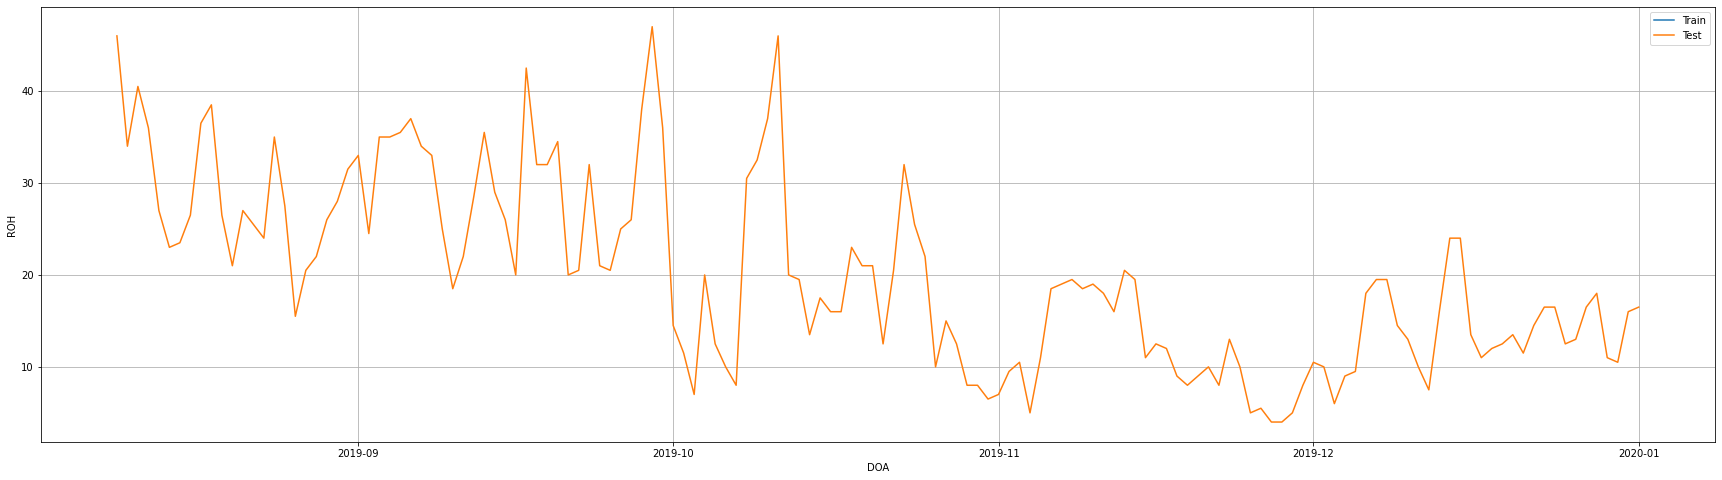

In [44]:
plt.plot(train[train['DBA']==0].index, train[train['DBA']==0]['ROH'], label='Train')
plt.plot(test[test['DBA']==0].index, test[test['DBA']==0]['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

In [37]:
df.columns

Index(['DBA', 'ROH_max', 'ROH_min', 'ROH', 'ROH_avg', 'ROH_std', 'DOW',
       'LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'Mon', 'Day'],
      dtype='object', name='HotelId')

In [42]:
cols = ['DBA', 'ROH_max', 'ROH_min', 'ROH', 'ROH_avg', 'ROH_std', 'DOW',
       'LAR_max', 'LAR_min', 'LAR_med', 'LAR_avg', 'LAR_std', 'Mon', 'Day']
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train[cols])

In [43]:
train[cols]

HotelId,DBA,ROH_max,ROH_min,ROH,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std,Mon,Day
DOA,,,,,,,,,,,,,,
2018-01-01 23:44:00,-1.712912,-1.940017,-1.044194,-0.951333,-1.451694,-1.768002,-1.494243,-0.632278,-0.657061,-0.266633,-0.469473,-0.514459,-1.436809,-1.649118
2018-01-01 23:28:00,-1.674419,-1.940017,-1.044194,-0.676367,-1.399943,-1.787016,-1.494243,-0.632278,-0.657061,-0.266633,-0.469473,-0.514459,-1.436809,-1.649118
2018-01-01 21:04:00,-1.327988,-1.879705,-0.963234,-0.876342,-1.385157,-1.715114,-1.494243,-0.632278,-0.657061,-0.266633,-0.469473,-0.514459,-1.436809,-1.649118
2018-01-01 20:48:00,-1.289495,-1.879705,-0.882274,-0.826348,-1.368729,-1.719676,-1.494243,-0.632278,-0.657061,-0.266633,-0.469473,-0.514459,-1.436809,-1.649118
2018-01-01 20:32:00,-1.251003,-1.785886,-0.882274,-0.826348,-1.322728,-1.637435,-1.494243,-0.632278,-0.657061,-0.266633,-0.469473,-0.514459,-1.436809,-1.649118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-07 00:48:00,1.597434,1.437460,2.113254,2.148290,1.927695,1.319824,-0.494658,-0.102036,0.313944,0.304450,0.287187,0.056387,0.733802,-0.969453
2019-08-07 00:32:00,1.635927,1.497773,2.194214,2.298272,2.019696,1.374072,-0.494658,0.173812,0.313944,0.287871,0.366815,0.291876,0.733802,-0.969453
2019-08-07 00:16:00,1.674419,1.558085,2.275174,2.373263,2.151947,1.439560,-0.494658,-0.256665,-0.171285,0.481668,0.225825,-0.214966,0.733802,-0.969453
